# Produce training data via SAME-ECOS simulation 

In [67]:
import SAME_ECOS_functions as se
from SAME_ECOS_functions import *
import time
import datetime
import numpy as np
import scipy.io as sio
import math
import itertools

In [13]:
### An example to display the usage of a SAME-ECOS function
se.T2_components_resolution_finite_domain(SNR=200, T2_min=3, T2_max=150)

3.5199999999999685

In [72]:
TE = np.arange(2,50,2)
TE

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48])

In [59]:
se.T2_boundary(SNR=100, echo_3=6, echo_last=48)

(2.0, 10.0)

In [21]:
T2_location = np.asarray([10,64,48])
T2_amplitude = np.asarray([0.2,0.5,0.3])

In [166]:
def mgre_signal(T2_location, T2_amplitude, TE, model=2):
    signal = np.zeros(TE.shape[0])
    alpha = (22/180)*math.pi
    TR = 100
    T1 = np.asarray([300,800,1000])
    T1_correction = np.sin(alpha)*(1-np.exp(-TR/T1))/(1-np.cos(alpha)*np.exp(-TR/T1))
    
    for t2_amp, t2_loc, t1_corr in zip(T2_amplitude, T2_location, T1_correction):
        if model == 1:
            signal += t2_amp * np.exp(-TE/t2_loc)
        if model == 2:
            signal += t2_amp * np.exp(-TE/t2_loc) * t1_corr
            
    return signal

In [158]:
signal = mgre_signal(T2_location, T2_amplitude, TE, model=2)
signal

array([0.23285983, 0.21725894, 0.20357747, 0.1914991 , 0.18076374,
       0.17115736, 0.16250369, 0.15465739, 0.14749852, 0.14092792,
       0.13486353, 0.12923729, 0.12399263, 0.11908245, 0.11446738,
       0.11011447, 0.10599599, 0.10208857, 0.09837238, 0.09483055,
       0.09144864, 0.08821422, 0.08511656, 0.08214627])

In [159]:
signal_noisy = se.signal_with_noise_generation_phase_rotation(signal, SNR=100)
signal_noisy

array([0.23726887, 0.21058465, 0.20271337, 0.18392028, 0.1797324 ,
       0.16954635, 0.15142136, 0.15507144, 0.14675567, 0.14710085,
       0.13737124, 0.14497251, 0.13398992, 0.11369571, 0.10371719,
       0.09680379, 0.10971687, 0.11799362, 0.08879089, 0.08884466,
       0.0880325 , 0.08907035, 0.07442222, 0.09207517])

In [188]:
def produce_mgre_data(realizations=10000,
                      SNR_boundary_low=50,
                      SNR_boundary_high=800,
                      echo_1st=2,
                      echo_last=48,
                      echo_spacing=2,
                      num_t2_basis=40,
                      peak_width=1,
                      T2_min_universal=3,
                      T2_max_universal=2000,
                      exclude_M_max=False):
    """
    Produce training data via SAME-ECOS simulation pipeline (use a single cpu core).

    Args:
        decay_lib (array): the decay library
        realizations (int, optional): the number of simulation realizations. Defaults to 10000.
        SNR_boundary_low (float, optional): lower boundary of SNR. Defaults to 50.
        SNR_boundary_high (float, optional): upper boundary of SNR. Defaults to 800.
        echo_3 (float, optional): the 3rd echo time in ms. Defaults to 30.
        echo_last (float, optional): the last echo time in ms. Defaults to 320.
        echo_train_num (int, optional): the number of echoes in the echo train. Defaults to 32.
        num_t2_basis (int, optional): the number of basis t2s. Defaults to 40.
        FA_min (float, optional): the minimal refocusing flip angle (degree) for simulation. Defaults to 50.
        peak_width (float, optional): the variance of the gaussian peak. Defaults to 1.
        T2_min_universal (float, optional): the overall minimal T2 (ms) of the analysis. Defaults to calculate on the fly if None is given.
        T2_max_universal (float, optional): the overall maximal T2 (ms) of the analysis. Defaults to to 2000ms if None is given.
        exclude_M_max (bool, optional): exclude the M_max if True. Defaults to True.

    Returns:
        data: dictionary collection of the produced training data
    """

    # Define T2 range, maximum number (M_max) of T2 peaks at the highest SNR, allowable number (N) of T2 peaks for simulation
    TE = np.arange(echo_1st, echo_last+echo_spacing, echo_spacing)
    echo_train_num = TE.shape[0]
    if T2_min_universal == None:
        # Lower boundary is determined by the highest SNR
        T2_min_universal, _ = T2_boundary(SNR_boundary_high, echo_3, echo_last)
    if T2_max_universal == None:
        T2_max_universal = 2000  # empirically determined
    t2_basis = t2_basis_generator(
        T2_min_universal, T2_max_universal, num_t2_basis)
    M_max = int(np.floor(T2_components_resolution_finite_domain(
        SNR_boundary_high, T2_min_universal, T2_max_universal)))  # M at highest SNR
    # resolution_max = resloution_limit(T2_min_universal, T2_max_universal, M_max) ## resolution at highest SNR
    if exclude_M_max == True:
        N = M_max - 1  # for simulation M_max is excluded
    else:
        N = M_max
    # Create placeholders for memory efficiency
    T2_location_all = np.zeros([realizations, N])
    T2_amplitude_all = np.zeros([realizations, N])
    decay_curve_all = np.zeros([realizations, echo_train_num])
    decay_curve_with_noise_all = np.zeros([realizations, echo_train_num])
    train_label_all = np.zeros([realizations, num_t2_basis])
    train_label_gaussian_all = np.zeros([realizations, num_t2_basis])
    num_T2_SNR_FA_all = np.zeros([realizations, 2])
    # For each realization
    for i in range(realizations):
        # Randomly determine the SNR, the minimum T2, the number of T2s (must < M), and the flip angle FA.
        # SNR = 100 ## for fixed SNR
        SNR = np.random.randint(SNR_boundary_low, SNR_boundary_high)
        T2_min, _ = T2_boundary(SNR, TE[2], TE[-1])
        if T2_min < T2_min_universal:
            T2_min = T2_min_universal
        T2_max = T2_max_universal
        M = np.floor(T2_components_resolution_finite_domain(
            SNR, T2_min, T2_max))
        if exclude_M_max == True:
            N_choice = np.arange(1, M)
        else:
            N_choice = np.arange(1, M+1)
        weight = N_choice**0.2  # weighting factor for each choice
        num_T2 = int(np.random.choice(N_choice, p=weight/weight.sum()))
        # Calculate the resolution limit
        resolution = resloution_limit(T2_min, T2_max, M)
        # Randomly generate T2 peak location with respect to resolution limit.
        #T2_location = T2_location_generator_v3(T2_min, T2_max, num_T2, num_t2_basis, resolution, log_cutoff=10, smooth=False)
        T2_location = T2_location_generator_v3(
            T2_min, T2_max, num_T2, M_max, scale='log')
        while T2_resolution_examiner(T2_location, resolution) == False:
            T2_location = T2_location_generator_v3(
                T2_min, T2_max, num_T2, M_max, scale='log')
        # Randomly generate T2 peak amplitude. When two or more peaks, minimal detectable amplitude is calculated
        if num_T2 == 1:
            T2_amplitude = np.array([1.0])
        else:
            _, frequency = required_frequency(T2_location)
            minimum_amplitude = minimum_amplitude_calculator(SNR, frequency)
            T2_amplitude = T2_amplitude_generator_v3(num_T2, minimum_amplitude)
        # Decay curve generation (weighted sum of each T2 component)
        decay_curve = mgre_signal(T2_location, T2_amplitude, TE, model=2)
        # Add noise to decay curve
        decay_curve_with_noise = signal_with_noise_generation_phase_rotation(
            signal=decay_curve, SNR=SNR)
        # T2 basis set embedding (nearest t2_basis neighbors)
        train_label = train_label_generator(
            T2_location, T2_amplitude, t2_basis)
        # T2 basis set embedding (gaussian peaks)
        train_label_gaussian = train_label_generator_gaussian_embedding(
            T2_location, T2_amplitude, T2_min_universal, T2_max_universal, t2_basis, peak_width)
        # Extract metrics (use t2_basis and train label instead of T2_location and T2_amplitude to prevent basis set embedding error)
        #MWF, MWGMT2, IEWF, IEWGMT2, GMT2 = metrics_extraction_v3(t2_basis, train_label, MW_low_cutoff, MW_high_cutoff, IEW_low_cutoff, IEW_high_cutoff)
        # Ground truth metrics (use tT2_location and T2_amplitude)
        #MWF_GT, MWGMT2_GT, IEWF_GT, IEWGMT2_GT, GMT2_GT = metrics_extraction_v3(T2_location, T2_amplitude, MW_low_cutoff, MW_high_cutoff, IEW_low_cutoff, IEW_high_cutoff)
        # Pad T2_location and T2_amplitude to have uniform size
        T2_location = np.pad(
            T2_location, [(0, N-int(num_T2))], mode='constant', constant_values=0)
        T2_amplitude = np.pad(
            T2_amplitude, [(0, N-int(num_T2))], mode='constant', constant_values=0)
        # Store generated parameters in placeholders
        T2_location_all[i, :] = T2_location
        T2_amplitude_all[i, :] = T2_amplitude
        decay_curve_all[i, :] = decay_curve
        decay_curve_with_noise_all[i, :] = decay_curve_with_noise
        train_label_all[i, :] = train_label
        train_label_gaussian_all[i, :] = train_label_gaussian
        num_T2_SNR_FA_all[i, :] = num_T2, SNR
    # return a data dict
    data = {'T2_location': T2_location_all,
            'T2_amplitude': T2_amplitude_all,
            'decay_curve': decay_curve_all,
            'decay_curve_with_noise': decay_curve_with_noise_all,
            'train_label': train_label_all,
            'train_label_gaussian': train_label_gaussian_all,
            'num_T2_SNR': num_T2_SNR_FA_all,
            }
    return data

In [189]:
data = produce_mgre_data(realizations=10000,
                         SNR_boundary_low=50,
                         SNR_boundary_high=300,
                         echo_1st=2,
                         echo_last=48,
                         echo_spacing=2,
                         num_t2_basis=40,
                         peak_width=1,
                         T2_min_universal=3,
                         T2_max_universal=2000,
                         exclude_M_max=False)

In [190]:
def mp_yield_mgre_data(func_produce_training_data,
                       realizations,
                       ncores,
                       SNR_boundary_low=50,
                       SNR_boundary_high=300,
                       echo_1st=2,
                       echo_last=48,
                       echo_spacing=2,
                       num_t2_basis=40,
                       peak_width=1,
                       T2_min_universal=3,
                       T2_max_universal=2000,
                       exclude_M_max=False):
    """
    Use multiple cpu cores to accelerate training data production using multiprocessing package.

    Args:
        func_produce_training_data (function): the function to produce training data using a single cpu core.
        decay_lib (array): the decay library.
        realizations (int): the number of simulation realizations.
        ncores (int): number of cpu cores to use.
        SNR_boundary_low (float, optional): lower boundary of SNR. Defaults to 50.
        SNR_boundary_high (float, optional): upper boundary of SNR. Defaults to 800.
        echo_3 (float, optional): the 3rd echo time (ms). Defaults to 30.
        echo_last (float, optional): the last echo time (ms). Defaults to 320.
        echo_train_num (int, optional): the number of echoes in the echo train. Defaults to 32.
        num_t2_basis (int, optional): the number of basis t2s. Defaults to 40.
        FA_min (float, optional): the minimal refocusing flip angle for simulation. Defaults to 50.
        peak_width (float, optional): the variance of the gaussian peak. Defaults to 1.
        T2_min_universal (float, optional): the overall minimal T2 (ms) of the analysis. Defaults to calculate on the fly if None is given.
        T2_max_universal (float, optional): the overall maximal T2 (ms) of the analysis. Defaults to to 2000ms if None is given.
        exclude_M_max (bool, optional): exclude the M_max if True. Defaults to True.

    Returns:
        data_all: a data dictionary concatenated from all cpu cores
    """

    import multiprocessing as mp
    pool = mp.Pool(processes=ncores)
    # distribute job to each cpu core
    realizations_pool_list = [realizations//ncores]*ncores
    if realizations % ncores != 0:
        realizations_pool_list.append(realizations % ncores)
    data = pool.starmap(func_produce_training_data, [(realizations,
                                                      SNR_boundary_low, SNR_boundary_high,
                                                      echo_1st, echo_last, echo_spacing,
                                                      num_t2_basis, peak_width,
                                                      T2_min_universal, T2_max_universal,
                                                      exclude_M_max)
                                                     for realizations in realizations_pool_list])
    pool.close()
    pool.join()
    # concatenate data calculated from each cpu core
    keys = data[0].keys()
    data_all = {key: None for key in keys}
    for key in keys:
        data_all[key] = np.concatenate(
            [data[x][key] for x in range(len(data))])
    return data_all

In [192]:
data = mp_yield_mgre_data(produce_mgre_data,
                          realizations=1000000,
                          ncores=8,
                          SNR_boundary_low=50,
                          SNR_boundary_high=300,
                          echo_1st=2,
                          echo_last=48,
                          echo_spacing=2,
                          num_t2_basis=40,
                          peak_width=1,
                          T2_min_universal=3,
                          T2_max_universal=2000,
                          exclude_M_max=False)

In [193]:
data['num_T2_SNR']

array([[  1., 118.],
       [  4., 115.],
       [  3., 286.],
       ...,
       [  5., 161.],
       [  2.,  60.],
       [  3., 154.]])

In [194]:
data.keys()

dict_keys(['T2_location', 'T2_amplitude', 'decay_curve', 'decay_curve_with_noise', 'train_label', 'train_label_gaussian', 'num_T2_SNR'])

produced training data contains
- T2_location: T2 peak locations of each realization
- T2_amplitude: T2 peak amplitudes of each realization
- decay_curve: the pure signal at each echo of each realization
- decay_curve_with_noise: the signal at each echo of each realization with noise added
- train_label: the T2 spectrum (each T2 peak is depicted by two nearest basis t2s)
- train_label_gaussian: the T2 spectrum (each T2 peak is depicted by gaussian shaped basis t2s)
- num_T2_SNR_FA: a collection array of number of T2 peaks, selected SNR, and selected flip angle of each realization

# SAME-ECOS model training

In [173]:
import sklearn
import tensorflow as tf
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

In [195]:
### store training input data in variable x
x = data['decay_curve_with_noise']
### normalization the input data to its first echo
x=x/x[:,0].reshape(x.shape[0],1) 
x.shape

(1000000, 24)

In [196]:
### store training label in variable y
y = data['train_label_gaussian']
y.shape

(1000000, 40)

In [197]:
### split the dataset into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=10)

In [198]:
print('training x: '+ str(x_train.shape))
print('training y: '+ str(y_train.shape))
print('validation x: '+ str(x_val.shape))
print('validation y: '+ str(y_val.shape))
print('testing x: '+ str(x_test.shape))
print('testing y: '+ str(y_test.shape))

training x: (810000, 24)
training y: (810000, 40)
validation x: (90000, 24)
validation y: (90000, 40)
testing x: (100000, 24)
testing y: (100000, 40)


In [199]:
### Setting up neural network hyperparameters
hidden_layers=[100, 500, 1000, 1000, 500] # a list of nodes in each hidden layer and can be changed as you wish
output_layer_nodes = y.shape[1]
Batch_norm = 'yes' # use batch normalization
acti='selu' # activation function
initial='lecun_normal' # weight initialization
selected_metrics=[tf.keras.metrics.CosineSimilarity(axis=-1)]
selected_optimizer = keras.optimizers.Adamax(lr=0.005)
# loss_function = 'cosine_similarity'
loss_function = 'categorical_crossentropy' # other loss functions can be used as well.
# loss_function = 'mean_squared_error'
l1_strength = 0.1 # L1 regularization parameter
l2_strength = 0.1 # L2 regularization parameter
num_epoch = 50

In [200]:
### Train and test the neural network model, and store training and testing history in 'NN_training.txt'
f = open("NN_training.txt", "a")
now = datetime.datetime.now()
f.write("Date and Time: {} \n".format(now.strftime("%Y-%m-%d %H:%M:%S")))
f.write('selected hidden layer structure = {} \n'.format(hidden_layers))
f.write('activation = {}, initialization = {} \n'.format(acti, initial))
f.write('Batch_norm = {}, loss_function = {}, regularization_strength = {},\nselected_optimizer = {} \n \n \n'.format(
    Batch_norm, loss_function, l2_strength, selected_optimizer))

keras.backend.clear_session()
model = keras.Sequential()
if Batch_norm == 'yes':
    model.add(keras.layers.BatchNormalization())
for nodes in hidden_layers:
    model.add(keras.layers.Dense(
        nodes, kernel_initializer=initial, activation=acti))
    if Batch_norm == 'yes':
        model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(output_layer_nodes, kernel_initializer=initial, activation='softmax',
          activity_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)))

model.compile(optimizer=selected_optimizer, loss=loss_function, metrics=selected_metrics)

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_cosine_similarity', patience=15),
                  keras.callbacks.ModelCheckpoint(filepath='NN_model_example.h5',monitor='val_cosine_similarity',save_best_only=True),
                  keras.callbacks.ReduceLROnPlateau(monitor='cosine_similarity', factor=0.5, patience=3)]

start_time = time.time()
history = model.fit(x_train, y_train, epochs=40, batch_size=256,
                    callbacks=callbacks_list, validation_data=(x_val, y_val))

print("--- %.2f seconds ---" % (time.time() - start_time))
f.write("--- Training time %.2f seconds --- \n" % (time.time() - start_time))
print('training stopped at epoch = {}'.format(len(history.history['lr'])))
f.write('training stopped at epoch = {} \n \n'.format(
    len(history.history['lr'])))
f.write('validation similarity = {} \n \n'.format(list(round(i, 4)
        for i in history.history['val_cosine_similarity'])))
f.write('learning rate = {} \n \n'.format(list(round(i, 6)
        for i in history.history['lr'])))

### apply trained model to the test set
NN_predict = model.predict(x_test)

### evaluate the model performance using cosine similarity scores
similarity_score = np.zeros((y_test.shape[0], 1))
for item in range(y_test.shape[0]):
    similarity_score[item, :] = cosine_similarity(
        NN_predict[item, :].reshape(1, -1), y_test[item, :].reshape(1, -1))
print('Average similarity for each spectrum in the test set = {} +/- {} \n'.format(
    similarity_score.mean(), similarity_score.std()))
f.write('Average similarity for each spectrum in the test set = {} +/- {} \n'.format(
    similarity_score.mean(), similarity_score.std()))
f.write('#############################################\n')
f.write('\n \n')
f.close()

Epoch 1/40
3165/3165 [==============================] - 33s 10ms/step - loss: 3.1214 - cosine_similarity: 0.6553 - val_loss: 3.0772 - val_cosine_similarity: 0.6668
Epoch 2/40
3165/3165 [==============================] - 32s 10ms/step - loss: 3.0353 - cosine_similarity: 0.6850 - val_loss: 3.0372 - val_cosine_similarity: 0.6847
Epoch 3/40
3165/3165 [==============================] - 32s 10ms/step - loss: 3.0148 - cosine_similarity: 0.6941 - val_loss: 3.0136 - val_cosine_similarity: 0.6962
Epoch 4/40
3165/3165 [==============================] - 32s 10ms/step - loss: 3.0006 - cosine_similarity: 0.7003 - val_loss: 3.0061 - val_cosine_similarity: 0.6984
Epoch 5/40
3165/3165 [==============================] - 32s 10ms/step - loss: 2.9739 - cosine_similarity: 0.7119 - val_loss: 2.9583 - val_cosine_similarity: 0.7187
Epoch 6/40
3165/3165 [==============================] - 32s 10ms/step - loss: 2.9520 - cosine_similarity: 0.7214 - val_loss: 2.9341 - val_cosine_similarity: 0.7308
Epoch 7/40
3165/

# Evaluate the trained model performance 

In [180]:
import matplotlib.pyplot as plt

In [201]:
### use 40 basis t2s to depict the spectrum  
t2_basis = se.t2_basis_generator(3,2000,40)

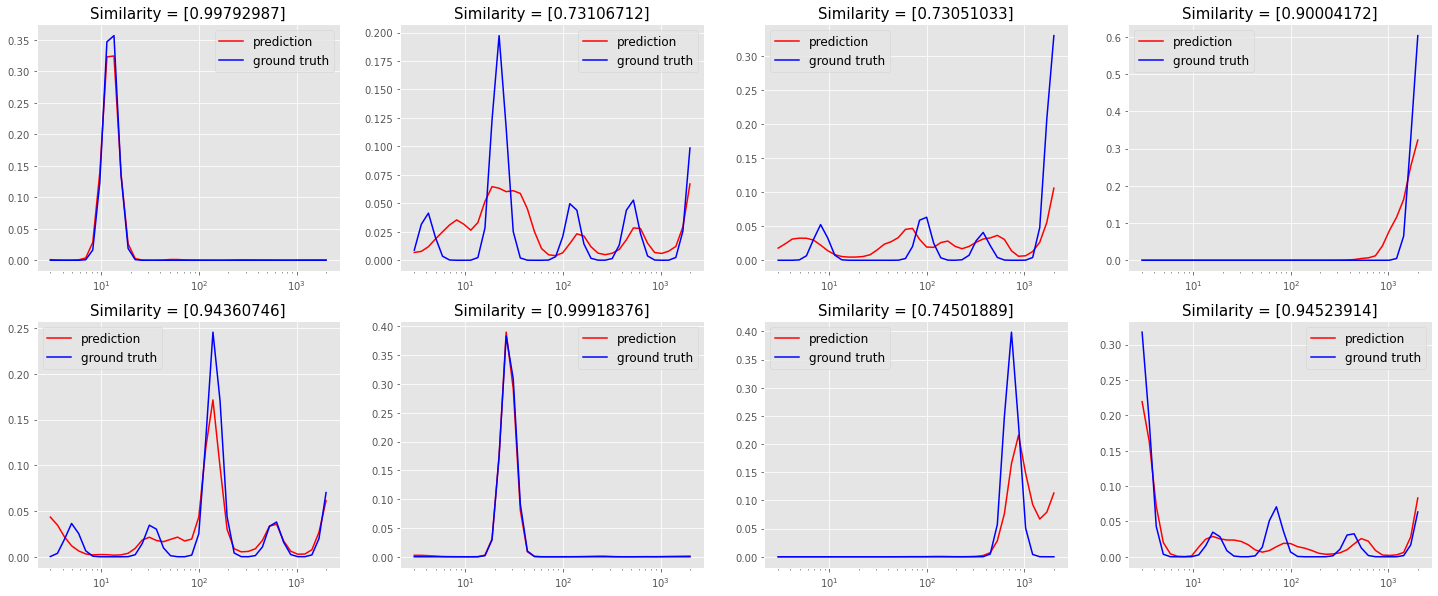

In [202]:
### randomly pick a few test examples and plot them
nrow = 2
ncol = 4
plt.figure(figsize=(25,10))
plt.style.use('ggplot')
for i in range(nrow*ncol):
    plt.subplot(nrow, ncol, i+1)
    random_pick = np.random.randint(0, y_test.shape[0])
    plt.plot(t2_basis, NN_predict[random_pick,:], 'r', label='prediction')
    plt.plot(t2_basis, y_test[random_pick,:], 'b', label='ground truth')
    plt.legend(fontsize=12)
    plt.xscale('log')
    plt.title('Similarity = {}'.format(similarity_score[random_pick]), fontsize=15)
plt.show()

In [ ]:
### uncomment the line below if you want to save the trained model
# model.save('NN_model.h5')

# Apply trained model to experimental data

- The experimental data is not provided in the on github repo. Pictures shown in this section only serves demonstration purpose.
- Please use your own MWI data.
- You should get similar results as shown in this section

In [128]:
import nibabel as nib

In [129]:
file_path = 'mGRE_T2star.nii' # replace with the path to your MWI image data in nii or nii.gz or mnc format
img = nib.load(file_path)
img_data = img.get_fdata()

In [134]:
# The last dimension should be the time axis (echoes)
img_data = np.swapaxes(img_data,0,2)
img_data.shape

(120, 106, 135, 24)

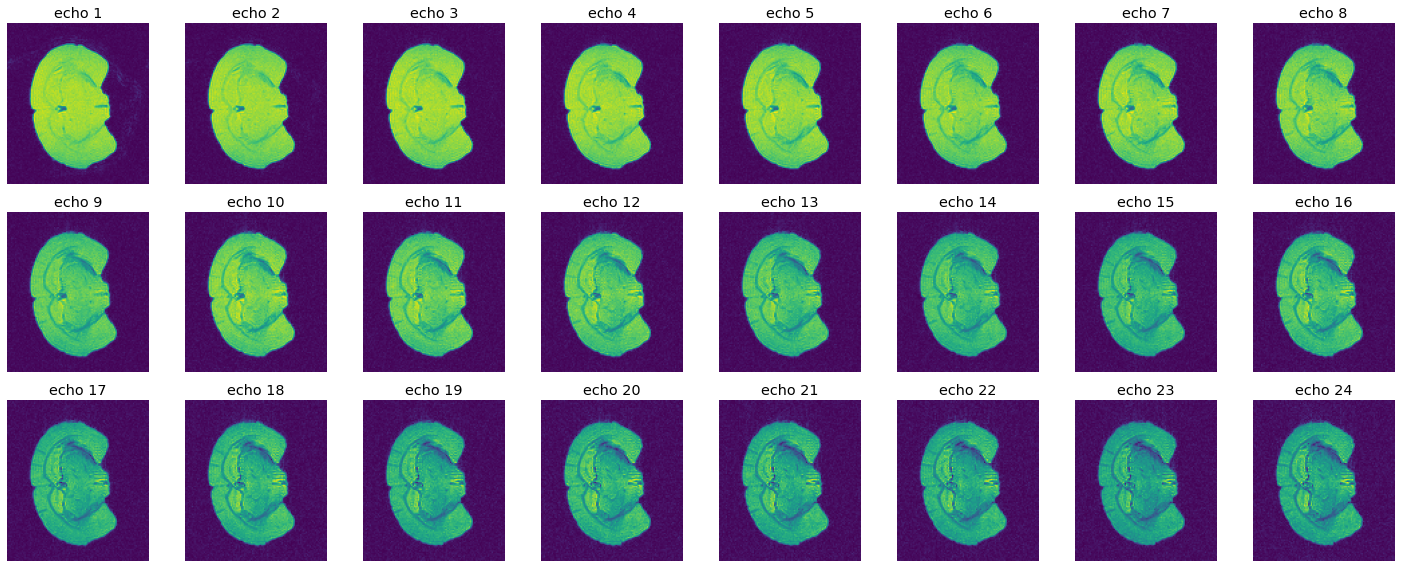

In [183]:
# The following function plots the 32 echoes for the 8th slice.
se.plot_all_echoes(img_data, slice_num=70, rows=3, columns=8, fig_size=(20,8), tight=True)

In [203]:
### Carry out the T2 spectrum using the neural network model trained above
NN_predict_spectrum = se.NN_predict_4D_decay(img_data, model)

In [204]:
### The last dimension of the 'se.quantitative_map_production' output the following 5 metrics (MWF, MWGMT2, IEWF, IEWGMT2, GMT2)
NN_predict_metrics = se.quantitative_map_production(t2_basis,
                                                    NN_predict_spectrum,
                                                    MW_low_cutoff=0,
                                                    MW_high_cutoff=25,
                                                    IEW_low_cutoff=25,
                                                    IEW_high_cutoff=150)

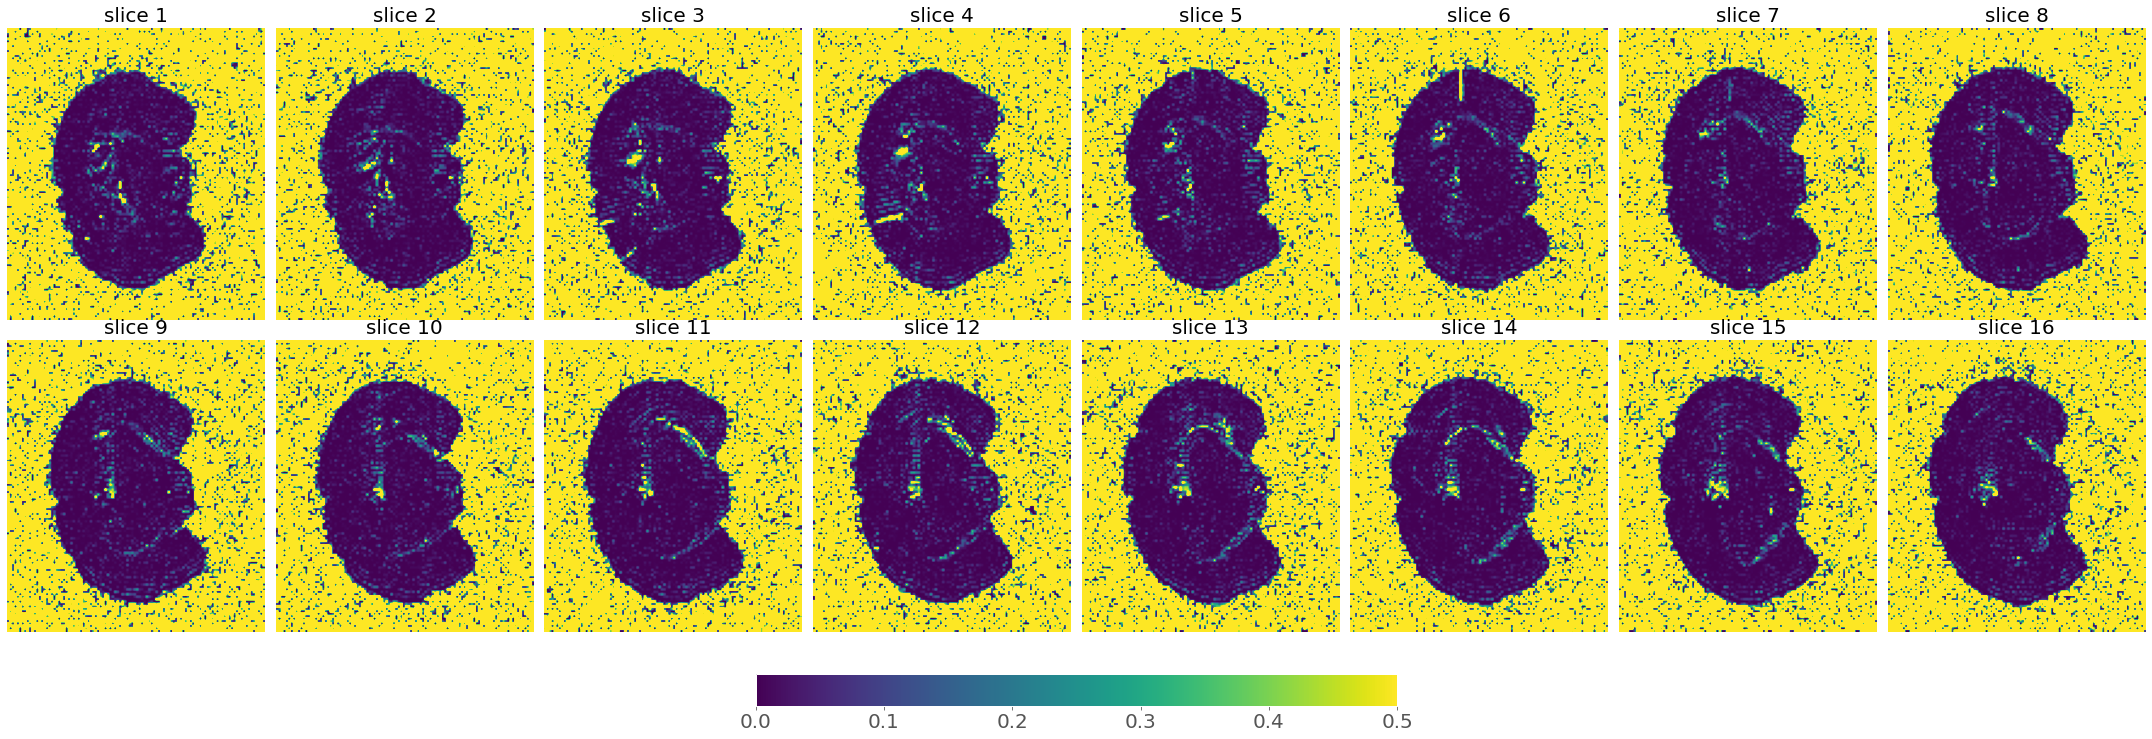

In [205]:
### plot the MWF map of all slices
se.plot_all_slice(NN_predict_metrics[:,:,60:76,0], nrow=2, ncol=8, vmin=0, vmax=0.5)